In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/xhding/workspaces/torch-deep-retina')
import os
import numpy as np
import h5py
import scipy.signal as ss
import torch
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap
from matplotlib import cm, colors
from matplotlib.ticker import FormatStrFormatter
from fnn.distributions import *
from fnn.notebook.utils import *
import fnn.models as models
from fnn.config import get_custom_cfg
from fnn.data import TestDataset, ValidationDataset
from fnn.evaluation import *
import json
from torchdeepretina.utils import inspect

In [3]:
with open('/home/xhding/tem_stim/15-11-21b_expt.json', 'r') as f:
    expt = json.load(f)

In [30]:
def spike_count(time_bin, each_timing):
    compare = (np.expand_dims(each_timing, -1) > time_bin)
    compare_next = np.zeros(compare.shape)
    compare_next[:, :-1] = compare[:, 1:]
    compare_next[:, -1] = False
    spikes = (compare != compare_next).sum(0)
    return spikes

def time_bin_from_stim(stim_time):
    stim_time = stim_time - stim_time[0]
    stim_time_int = np.append(np.diff(stim_time), 0.03)
    time_bin = np.zeros(stim_time.shape[0]*3)
    time_bin[0::3] = stim_time
    time_bin[1::3] = stim_time + stim_time_int/3
    time_bin[2::3] = stim_time + stim_time_int*2/3
    return time_bin

with open('/home/xhding/tem_stim/15-11-21b_expt.json', 'r') as f:
    expt = json.load(f)
g = h5py.File('/home/TRAIN_DATA/15-11-21b/naturalscene.h5', 'r')

h = h5py.File('/home/xhding/tem_stim/photodiode.h5', 'r')
pd = np.array(h['photodiode']['15-11-21-r2'])
peaks = ss.find_peaks(pd, height=1800, distance=90)[0]

test_indices = list(range(3, 24, 4))
cells = [0, 1, 9, 13, 14, 16, 18, 20, 21, 23, 25]

num_trials = len(test_indices)
num_bins = len(expt['stim'][test_indices[0]]['timestamps']) * 3
num_cells = len(cells)
repeats = np.zeros((num_trials, num_cells, num_bins))

for trial, idx in enumerate(test_indices):
    stim_time = np.array(expt['stim'][idx]['timestamps']).squeeze()
    time_bin = time_bin_from_stim(stim_time)
    each_start = peaks[9 + 12*trial] / 10000.
    each_end = each_start + expt['stim'][idx]['timestamps'][-1][0] - expt['stim'][idx]['timestamps'][0][0]
    for cell_idx, cell in enumerate(cells):
        timing = np.array(g['spikes']['cell{:02}'.format(cell+1)])
        each_timing = timing[(timing>each_start) * (timing<each_end)] - each_start
        repeats[trial, cell_idx, :time_bin.shape[0]] = spike_count(time_bin, each_timing)

In [31]:
with h5py.File('/home/xhding/tem_stim/15-11-21b/naturalscene_test.h5', 'w') as f:
    f.create_dataset('test/stimulus', data=g['test/stimulus'])
    f.create_dataset('test/response/binned', data=g['test/response/binned'])
    f.create_dataset('test/response/firing_rate_10ms', data=g['test/response/firing_rate_10ms'])
    f.create_dataset('test/repeats/binned', data=repeats[:,:,:-4])

In [30]:
noise_cor = noise_corr2(np.swapaxes(repeats, 1, 2))
stim_cor = stim_corr2(np.swapaxes(repeats, 1, 2))
num_cells = 17
diagonal_idxs = list(range(0, num_cells*num_cells, num_cells+1))
trial_cor = stim_cor.flatten()[diagonal_idxs]
stim_cor = np.delete(stim_cor.flatten(), diagonal_idxs)
noise_cor = np.delete(noise_cor.flatten(), diagonal_idxs)

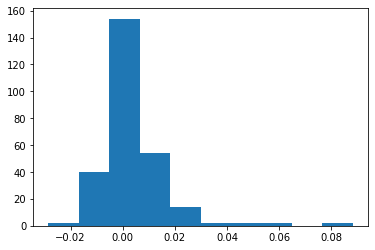

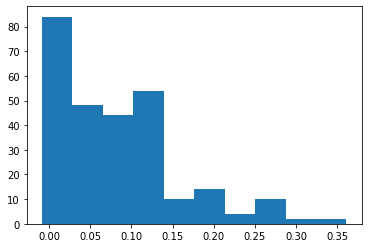

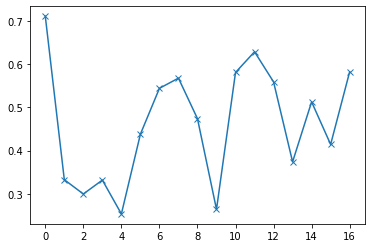

In [31]:
plt.hist(noise_cor)
plt.show()
plt.hist(stim_cor)
plt.show()
plt.plot(trial_cor, 'x-')
plt.show()

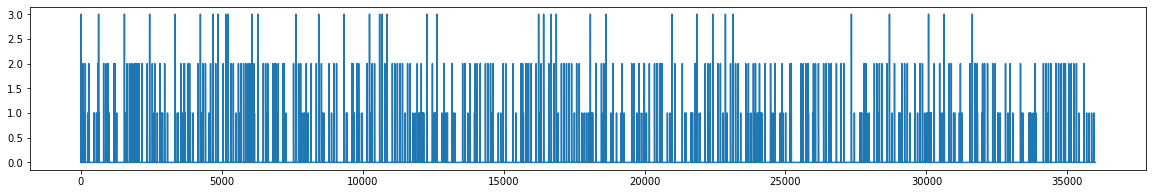

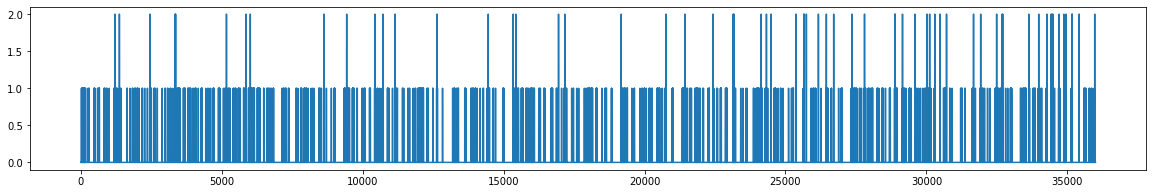

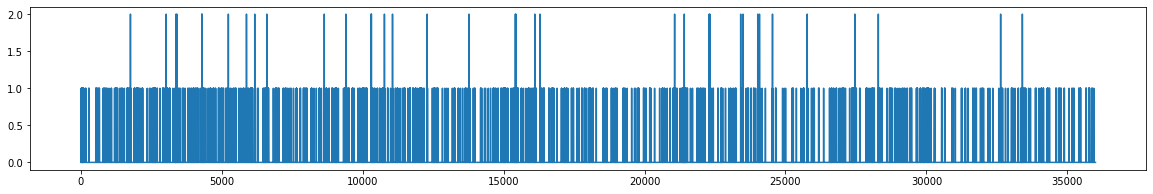

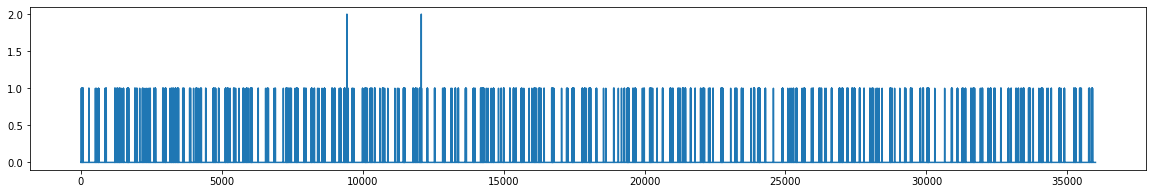

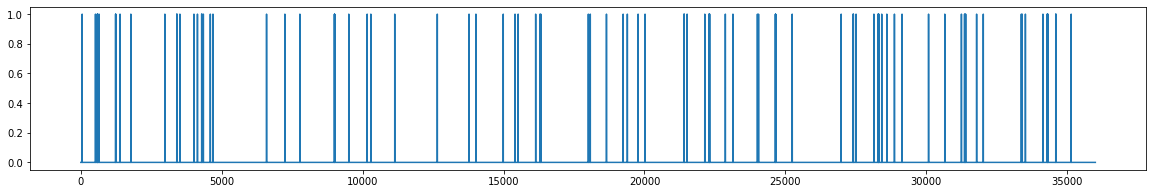

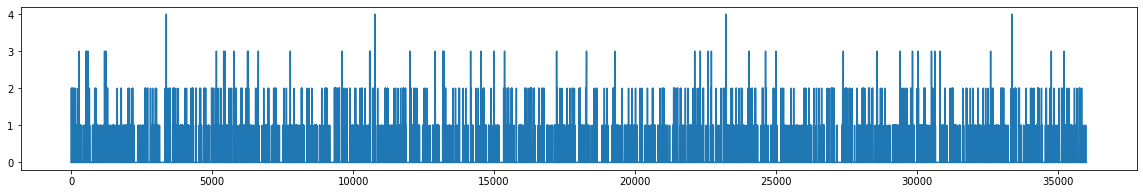

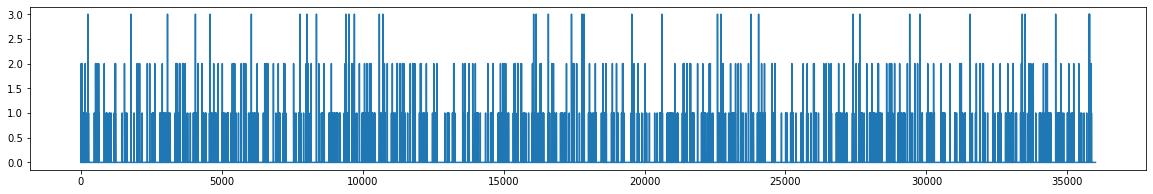

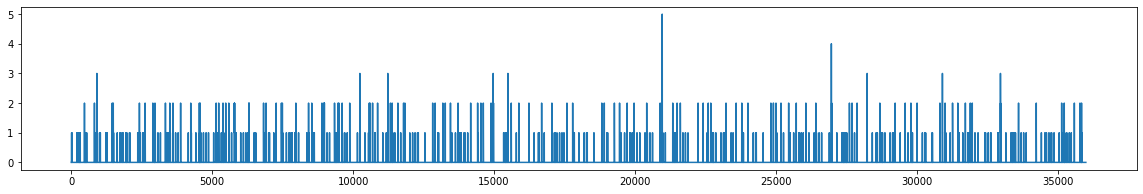

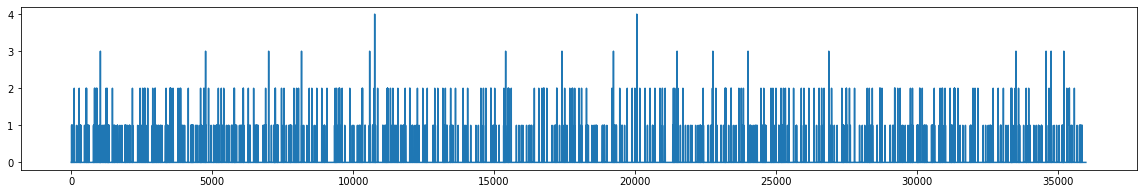

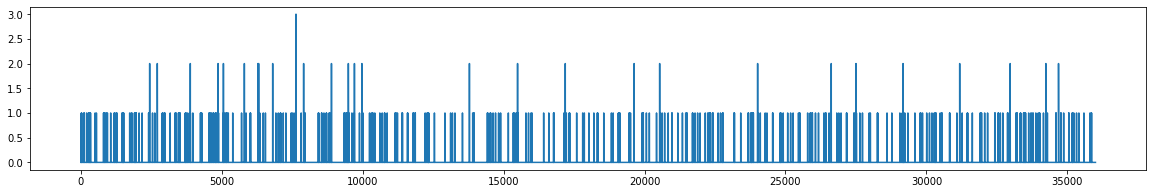

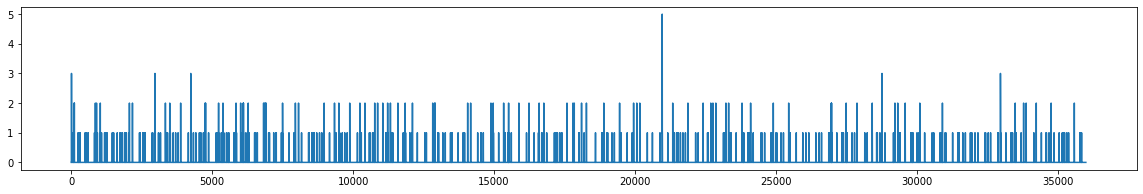

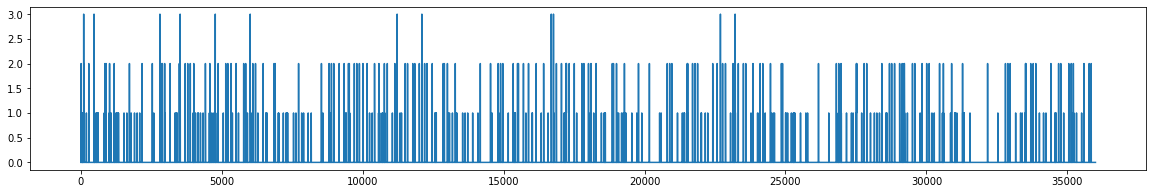

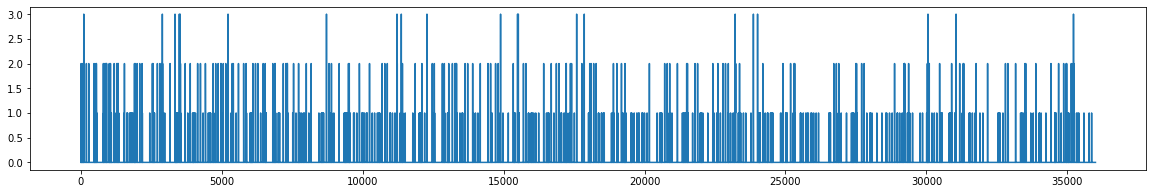

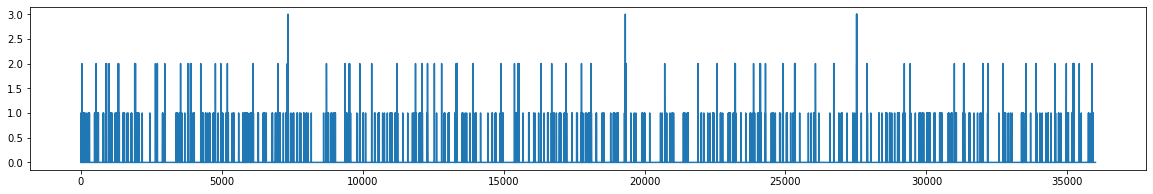

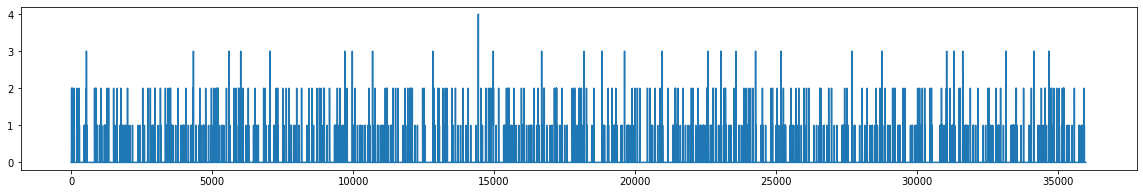

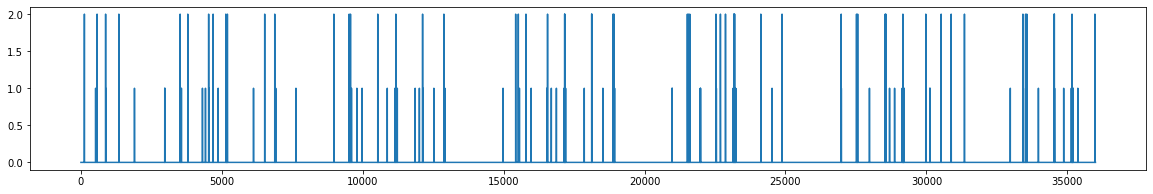

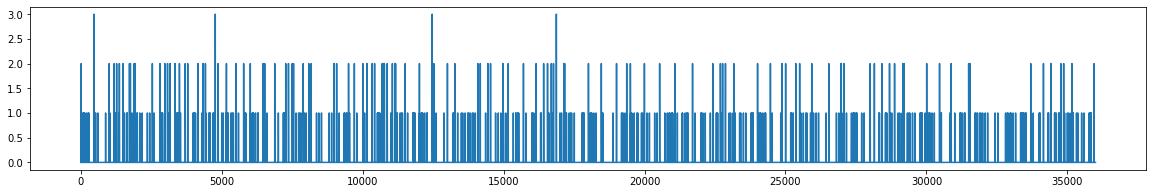

In [39]:
repeats_concat = np.concatenate(repeats, axis=1)
for cell in range(repeats_concat.shape[0]):
    plt.figure(figsize=(20,3))
    plt.plot(repeats_concat[cell])
    plt.show()

In [53]:
for cell in range(repeats.shape[1]):
    print(cell, (repeats[:,cell] >= repeats.max((0,2))[cell]).sum(), (repeats[:,cell] >= repeats.max((0,2))[cell]-1).sum(), (repeats[:,cell] >= repeats.max((0,2))[cell]-2).sum(), repeats.max((0,2))[cell])

0 37 341 1061 3.0
1 65 1382 36000 2.0
2 38 1529 36000 2.0
3 2 1318 36000 2.0
4 101 36000 36000 1.0
5 4 51 632 4.0
6 39 346 1764 3.0
7 1 2 11 5.0
8 2 18 288 4.0
9 1 29 546 3.0
10 1 2 7 5.0
11 12 230 911 3.0
12 22 271 1334 3.0
13 4 114 1319 3.0
14 1 33 314 4.0
15 62 261 36000 2.0
16 4 146 1106 3.0


In [3]:
file_path = '/home/xhding/tem_stim/15-11-21b/naturalscene_test.h5'
cells = list(range(11))
t_list = [4, 3, 4, 4, 4, 4, 3, 3, 4, 4, 3]
recording = recording_stats(file_path, cells)
recording_cut = recording_stats(file_path, cells, truncate=True, t_list=t_list)
single_trial_bin = recording.single_trial_bin
single_trial_bin_cut = recording_cut.single_trial_bin

In [52]:
for cell in range(17):
    dist = distribution(t_list[cell])
    try:
        print(cell, dist.optimize_k('binomial_scale', single_trial_bin_cut, cell))
    except:
        print(cell)

0 1.7470703125
1 1.615234375
2 1.8349609375
3
4
5 1.52734375
6 1.4833984375
7 1.6240234375
8 1.4130859375
9 1.2724609375
10 1.650390625
11 1.6416015625
12 1.5009765625
13 1.2724609375
14 1.3779296875
15
16 1.685546875


In [63]:
dist = distribution(t_list[15])
dist.optimize_k('binomial_scale', single_trial_bin_cut, 15, a=0.5, b=0.8)

0.5656249999999999

In [65]:
dist = distribution(t_list[11])
dist.optimize_k('binomial_scale', single_trial_bin_cut, 11)

1.228515625

In [67]:
optimum_para = {}
optimum_para['binomial'] = [1.75, 1.62, 1.83, 1., 1., 1.53, 1.48, 1.62, 1.41, 1.27, 1.65, 1.23, 1.50, 1.27, 1.38, 0.57, 1.69]
stats = variance_mean(recording, t_list, optimum_para)

0


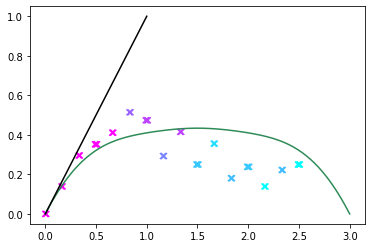

1


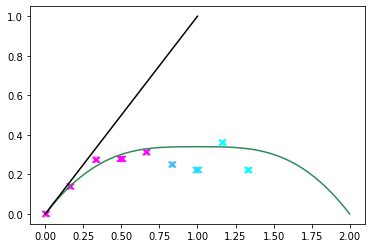

2


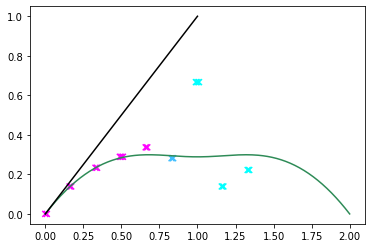

3


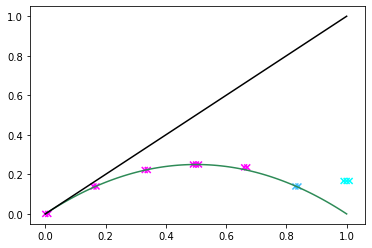

4


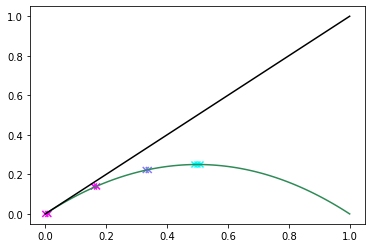

5


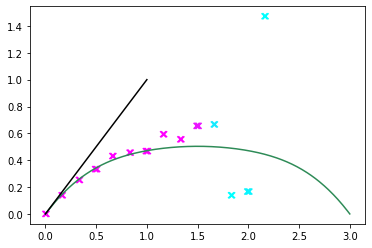

6


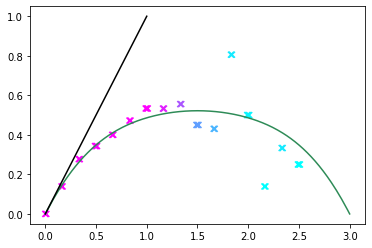

7


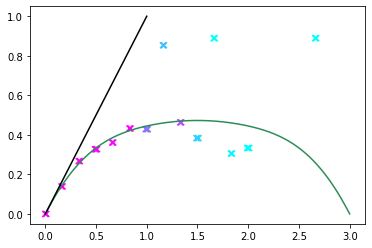

8


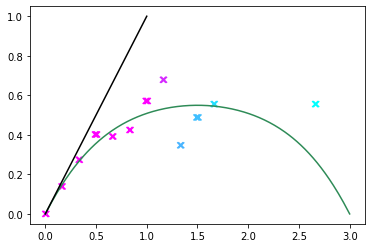

9


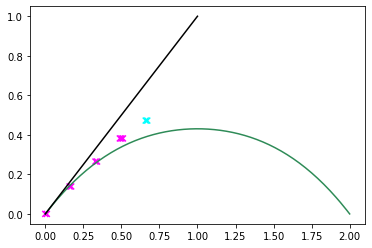

10


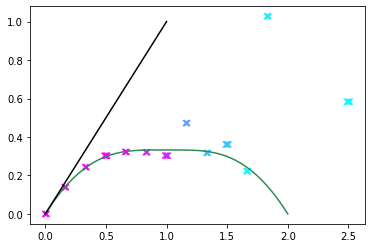

11


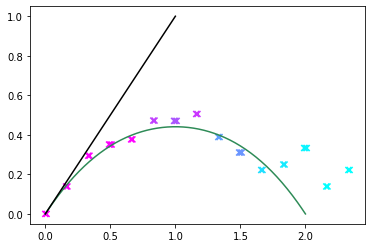

12


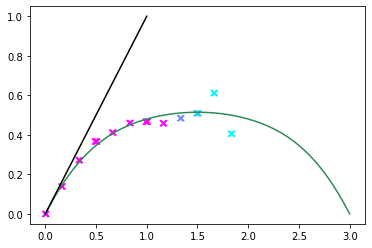

13


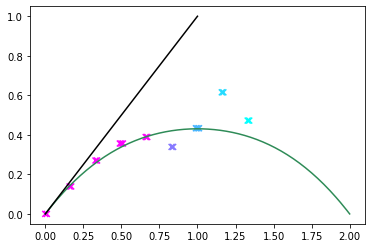

14


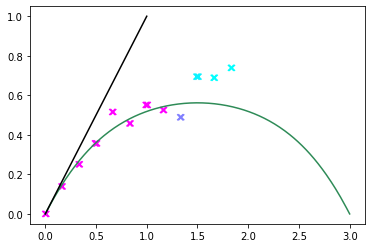

15


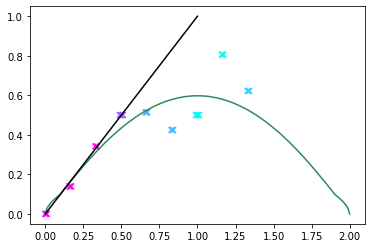

16


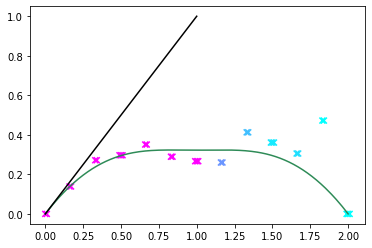

In [68]:
for cell in range(17):
    print(cell)
    plt.scatter(stats[cell]['means'], stats[cell]['variances'], c=stats[cell]['weights'], marker='x', cmap='cool', vmax=150, label='empirical')
    plt.plot(stats[cell]['means_dis'], stats[cell]['vars_dis'], '-', color='#2E8B57', label='binomial')
    plt.plot([0, 1], [0, 1], 'k')
    plt.show()

In [34]:
device = torch.device('cuda:6')
cfg = get_custom_cfg('bn_cnn_stack_15-11-21b')
model_func = getattr(models, cfg.Model.name)
model_kwargs = dict(cfg.Model)
model = model_func(**model_kwargs).to(device)
checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_045_loss_-9.61_pearson_0.7371.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
test_data = DataLoader(TestDataset(cfg), batch_size=500)
test_pc, pred, targ = pearsonr_batch_eval(model, test_data, 11, device)

In [27]:
pearsonr_eval_cell(model, test_data, 11, device)

[0.779038429595259,
 0.6995514949025944,
 0.7223245051558491,
 0.7345246457800884,
 0.6960419216284843,
 0.6803894213564488,
 0.7138407098913575,
 0.7699445425205593,
 0.7694867756901633,
 0.7751931895292685,
 0.755341630271381]

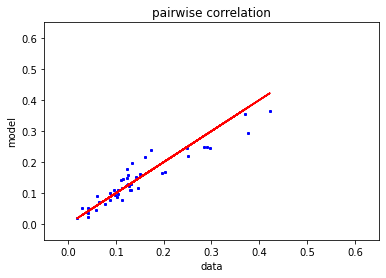

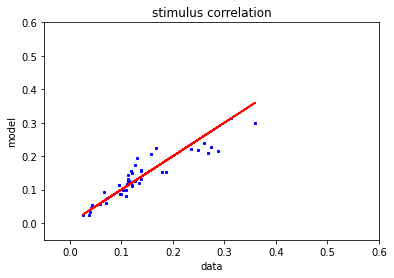

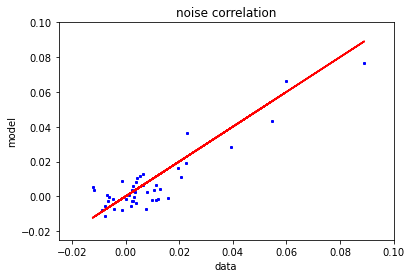

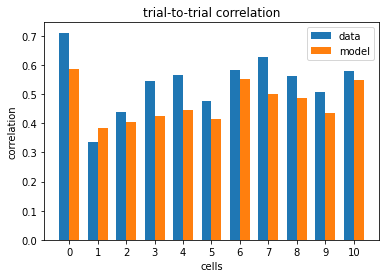

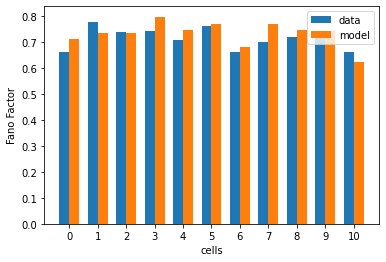

0.0062601189532032215


In [77]:
binomial_para = [1.75, 1.62, 1.53, 1.48, 1.62, 1.41, 1.65, 1.23, 1.50, 1.38, 1.69]
t_list = [4, 3, 4, 4, 4, 4, 3, 3, 4, 4, 3]
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 6, [1.5, 0, 0., 0.], seed=None)
poly_paras = poly_para_fit(recording, pred_single_trial_pre.copy(), pred, thre=7, threshold=0.3, intv=0.5, sigma=True)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, seed=None, thre=7)
ignore_idxs = [5*11+i for i in range(11)] + [i*11 + 5 for i in range(11)]

min_error = 10
for i in range(300):
    pred_single_trial = pred_single_trial_multi[i]
    error = error_corr2(single_trial_bin, pred_single_trial, ignore_idxs=ignore_idxs)
    if error < min_error:
        min_error = error
        pred_single_trial_try = pred_single_trial
        
correlation_plot_2(single_trial_bin, pred_single_trial_try, ignore_idxs)
print(min_error)

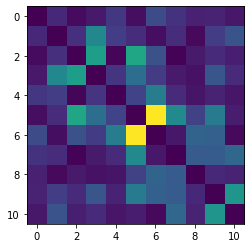

In [79]:
diff = np.abs(noise_corr2(single_trial_bin) - noise_corr2(pred_single_trial_try))
for i in range(11):
    diff[i, i] = 0
plt.imshow(diff)

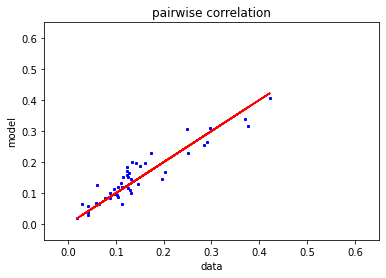

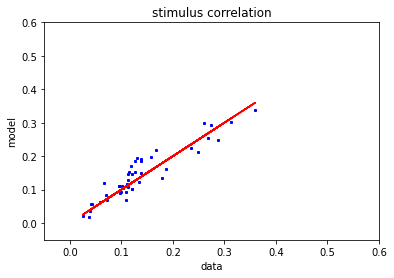

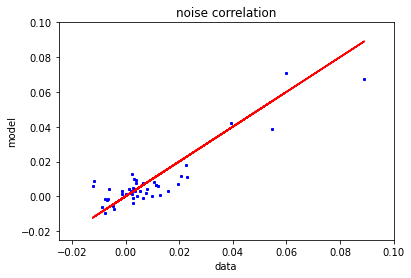

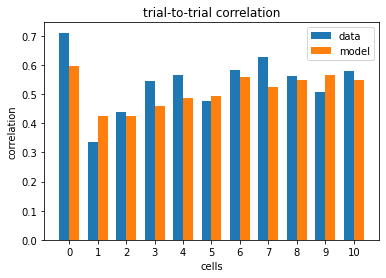

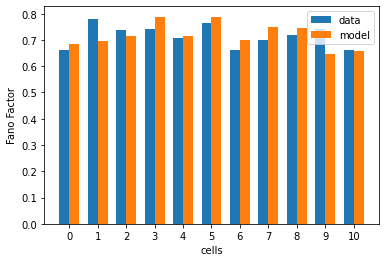

0.006238394617440715


In [78]:
binomial_para = [1.75, 1.62, 1.53, 1.48, 1.62, 1.41, 1.65, 1.23, 1.50, 1.38, 1.69]
t_list = [4, 3, 4, 4, 4, 4, 3, 3, 4, 4, 3]
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 6, [1.5, 0., 0., 0.], seed=None)
poly_paras = poly_para_fit(recording, pred_single_trial_pre.copy(), pred, thre=10, threshold=0.3, intv=0.5, sigma=True)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, seed=None, thre=10)
ignore_idxs = [5*11+i for i in range(11)] + [i*11 + 5 for i in range(11)]

min_error = 10
for i in range(300):
    pred_single_trial = pred_single_trial_multi[i]
    error = error_corr2(single_trial_bin, pred_single_trial, ignore_idxs)
    if error < min_error:
        min_error = error
        pred_single_trial_try = pred_single_trial
        
correlation_plot_2(single_trial_bin, pred_single_trial_try, ignore_idxs)
print(min_error)

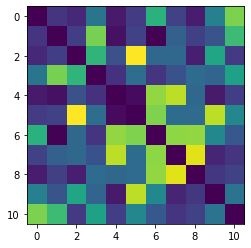

In [71]:
diff = np.abs(noise_corr2(single_trial_bin) - noise_corr2(pred_single_trial_try))
for i in range(11):
    diff[i, i] = 0
plt.imshow(diff)

In [72]:
[5*11+i for i in range(11)] + [i*11 + 5 for i in range(11)]

[55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 5,
 16,
 27,
 38,
 49,
 60,
 71,
 82,
 93,
 104,
 115]

In [62]:
single_trial_bin.sum(), pred_single_trial_try.sum()

(20007.0, 16173)

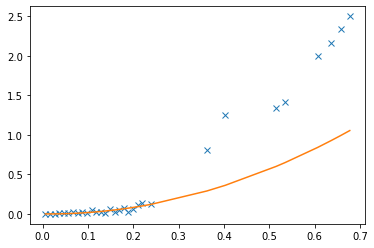

In [49]:
def poly(x,c,d):
        return c*x**2+d*x
    
cell = 0
means = []
rates = []
sigmas = []
thre = 1.5
pred_single_trial[:, pred<thre] = 0
for rate in np.linspace(0.6, pred_single_trial_pre.mean(0)[:, cell].max(), 100):
    mean, var, _, w = recording.stats_rate(pred_single_trial_pre.mean(0), cell=cell, rate=rate, intv=0.5)
    if var > 0:
        sigmas.append(np.sqrt(var/(w-1)))
        means.append(mean)
        rates.append(rate/100)
sigmas = np.array(sigmas)[~np.isnan(means)]
rates = np.array(rates)[~np.isnan(means)]
means = np.array(means)[~np.isnan(means)]

max_idx = np.where(means >= 0.8*means.max())[0][-1]
min_idx = np.where(rates == rates.min())[0][0]
slope = (means[max_idx] -  means[min_idx]) / (rates[max_idx] -  rates[min_idx])
means_res = means - (rates - rates[min_idx]) * slope - means[min_idx]
valid_idx = np.where(np.abs(means_res/means[max_idx]) < 0.3)

rates = rates[valid_idx]
means = means[valid_idx]
sigmas = sigmas[valid_idx]

para = curve_fit(poly, rates, means, sigma=sigmas)[0]

plt.plot(rates, means, 'x')
plt.plot(rates, [poly(rates[i], *para) for i in range(len(rates))])

In [58]:
binomial_para = [1.75, 1.62, 1.53, 1.48, 1.62, 1.41, 1.65, 1.23, 1.50, 1.38, 1.69]
t_list = [4, 3, 4, 4, 4, 4, 3, 3, 4, 4, 3]
for seed in range(100):
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 6, [1.2, 0, 0.05, 0.], seed=seed)
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, seed=seed, thre=15)

    min_error = 10
    for i in range(300):
        pred_single_trial = pred_single_trial_multi[i]
        error = error_corr2(single_trial_bin, pred_single_trial)
        if error < min_error:
            min_error = error
    print(seed, min_error)

0 0.01225871203201776
1 0.013163384599444845
2 0.014536696821440537
3 0.012024792735336229
4 0.01757628459154886
5 0.01673161803986203
6 0.015922260234471883
7 0.017062399939317602
8 0.018534243678226477
9 0.014184321185588745
10 0.016145196215280884
11 0.018323530817920965
12 0.013344348701937134
13 0.016475459352266197
14 0.016118879214125317
15 0.015712739814335533
16 0.01583898190366255
17 0.01692583405944544
18 0.012511434756683851
19 0.01574560975053096
20 0.01620427374193502
21 0.014413604561181913
22 0.016331559054353302
23 0.014248907760184169
24 0.012405667966282372
25 0.01478752885124105
26 0.018014997462165436
27 0.018117295977337702
28 0.013738341500937465
29 0.016971337092914957
30 0.012645972043539856
31 0.016029883431030317
32 0.0190650171916211
33 0.014517472934136681
34 0.013925386572310308
35 0.013385452212156508
36 0.01340486614158031
37 0.015624583690020876
38 0.017400371164099922
39 0.010099225067249615
40 0.01580343412378256
41 0.013374284920381334
42 0.019785980

### FC Model

In [5]:
device = torch.device('cuda:0')
cfg = get_custom_cfg('fc_15-11-21b')
model_func = getattr(models, cfg.Model.name)
model_kwargs = dict(cfg.Model)
model = model_func(**model_kwargs).to(device)
checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack_FC_2/epoch_015_loss_-8.56_pearson_0.6841.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
test_data = DataLoader(TestDataset(cfg), batch_size=500)
test_pc, pred, targ = pearsonr_batch_eval(model, test_data, 11, device)

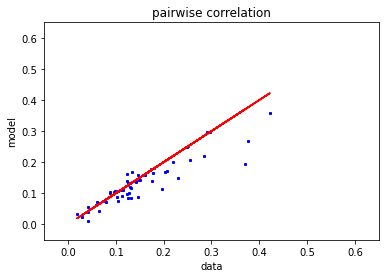

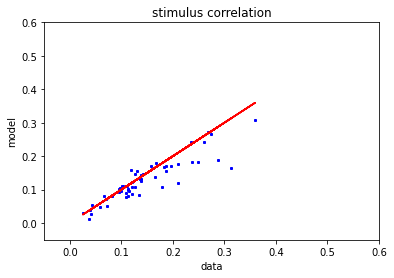

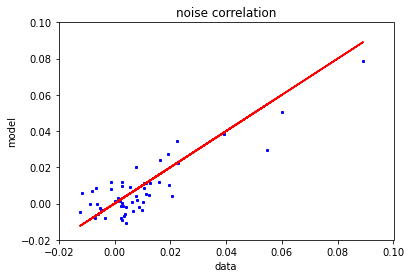

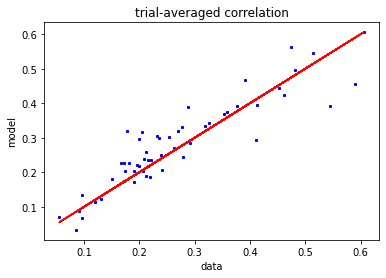

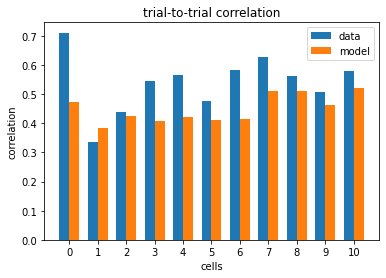

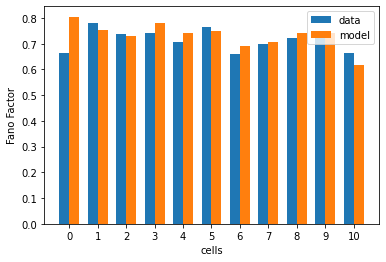

0.008881070477237837


In [56]:
binomial_para = [1.75, 1.62, 1.53, 1.48, 1.62, 1.41, 1.65, 1.23, 1.50, 1.38, 1.69]
t_list = [4, 3, 4, 4, 4, 4, 3, 3, 4, 4, 3]
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 6, [1.2, 0.07, 0., 0.], seed=3, noise_locs=[3,4,5])
poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, seed=3, thre=15)

min_error = 10
for i in range(300):
    pred_single_trial = pred_single_trial_multi[i]
    error = error_corr2(single_trial_bin, pred_single_trial)
    if error < min_error:
        min_error = error
        pred_single_trial_try = pred_single_trial
        
correlation_plot_2(single_trial_bin, pred_single_trial_try)
print(min_error)

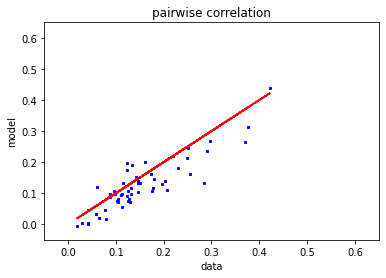

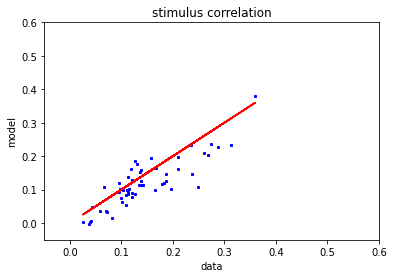

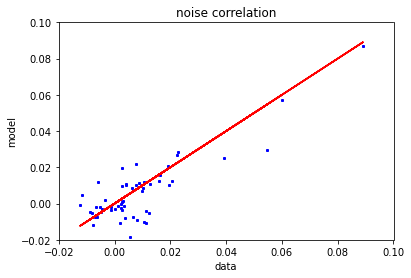

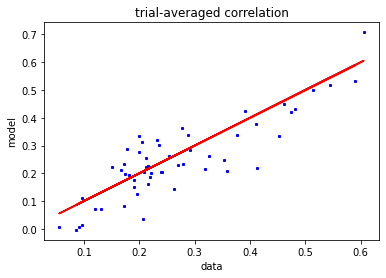

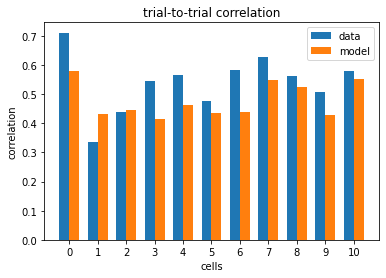

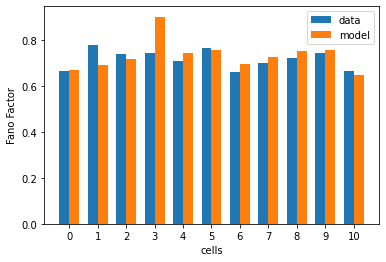

0.010896284382273606


In [46]:
binomial_para = [1.75, 1.62, 1.53, 1.48, 1.62, 1.41, 1.65, 1.23, 1.50, 1.38, 1.69]
t_list = [4, 3, 4, 4, 4, 4, 3, 3, 4, 4, 3]
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 6, [1.5, 0., 0., 0.], seed=6, noise_locs=[3,4,5])
poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, seed=6, thre=20)

min_error = 10
for i in range(300):
    pred_single_trial = pred_single_trial_multi[i]
    error = error_corr2(single_trial_bin, pred_single_trial)
    if error < min_error:
        min_error = error
        pred_single_trial_try = pred_single_trial
        
correlation_plot_2(single_trial_bin, pred_single_trial_try)
print(min_error)

In [65]:
for seed in range(100):
    binomial_para = np.array([1.75, 1.62, 1.53, 1.48, 1.62, 1.41, 1.65, 1.23, 1.50, 1.38, 1.69]) + 0.7
    t_list = [4, 3, 4, 4, 4, 4, 3, 3, 4, 4, 3]
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 6, [0., 0., 0.22, 0.], seed=seed, noise_locs=[3,4,5])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, seed=seed, thre=20)

    min_error = 10
    for i in range(300):
        pred_single_trial = pred_single_trial_multi[i]
        _, error_stim, error = error_corr3(single_trial_bin, pred_single_trial)
        if error < min_error:
            min_error = error
            min_error_stim = error_stim
    print(seed, min_error, min_error_stim)

0 0.023308987813479246 0.0740763612580654
1 0.02326215498227078 0.07863463950729323
2 0.026328014079165695 0.09136117464757006
3 0.02405145963110415 0.07816874874437037
4 0.021390138196021712 0.08782726207103511
5 0.023034880821957354 0.058266576720992544
6 0.025122768519959742 0.0783543270637519
7 0.02398760571266947 0.07192757036523774


KeyboardInterrupt: 

In [45]:
binomial_para = [1.75, 1.62, 1.53, 1.48, 1.62, 1.41, 1.65, 1.23, 1.50, 1.38, 1.69]
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 6, [1.5, 0, 0., 0], noise_locs=[3,4,5])
poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, seed=None, thre=0)
for thre in np.arange(10, 25, 1):
    pred_single_trial_multi[:, :, pred<thre] = 0
    min_error = 10
    for i in range(300):
        pred_single_trial = pred_single_trial_multi[i]
        error = error_corr2(single_trial_bin, pred_single_trial)
        if error < min_error:
            min_error = error
            pred_single_trial_try = pred_single_trial

    print(thre, variability_error(single_trial_bin, pred_single_trial_try))

10 3.533581591259048
11 3.323768506415295
12 3.2094227823568073
13 3.0619058579718215
14 2.915430955180842
15 2.7149412265211086
16 2.700079386139068
17 2.624749916059808
18 2.6056762545439915
19 2.097590880901027
20 2.0728923233855094
21 2.2659728632331833
22 2.1124351306612037
23 2.153122001486302
24 2.1442505870813506


In [50]:
g2_errors = []
g1_errors = []
g0_errors = []

t_list = [4, 3, 4, 4, 4, 4, 3, 3, 4, 4, 3]

for g2 in np.linspace(0., 0.3, 51):
    binomial_para = [1.75, 1.62, 1.53, 1.48, 1.62, 1.41, 1.65, 1.23, 1.50, 1.38, 1.69]
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 6, [0, 0, g2, 0], noise_locs=[3,4,5])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, thre=20)
    
    min_error = 10
    
    for i in range(300):
        pred_single_trial = pred_single_trial_multi[i]
        _, stim_error, noise_error = error_corr3(single_trial_bin, pred_single_trial)
        if noise_error < min_error:
            min_error = noise_error
            min_error_stim = stim_error
         
    g2_errors.append((g2, min_error_stim, min_error))

for g1 in np.linspace(0., 0.3, 51):
    binomial_para = [1.75, 1.62, 1.53, 1.48, 1.62, 1.41, 1.65, 1.23, 1.50, 1.38, 1.69]
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 6, [0, g1, 0, 0],  noise_locs=[3,4,5])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, thre=20)
    
    min_error = 10
    
    for i in range(300):
        pred_single_trial = pred_single_trial_multi[i]
        _, stim_error, noise_error = error_corr3(single_trial_bin, pred_single_trial)
        if noise_error < min_error:
            min_error = noise_error
            min_error_stim = stim_error
         
    g1_errors.append((g1, min_error_stim, min_error))

for g0 in np.linspace(0, 3, 51):
    binomial_para = [1.75, 1.62, 1.53, 1.48, 1.62, 1.41, 1.65, 1.23, 1.50, 1.38, 1.69]
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 6, [g0, 0, 0, 0],  noise_locs=[3,4,5])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, thre=20)
    
    min_error = 10
    
    for i in range(300):
        pred_single_trial = pred_single_trial_multi[i]
        _, stim_error, noise_error = error_corr3(single_trial_bin, pred_single_trial)
        if noise_error < min_error:
            min_error = noise_error
            min_error_stim = stim_error
         
    g0_errors.append((g0, min_error_stim, min_error))

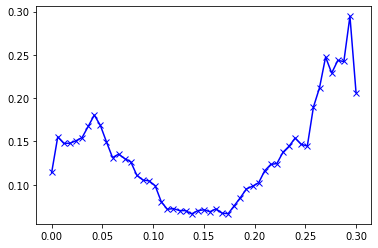

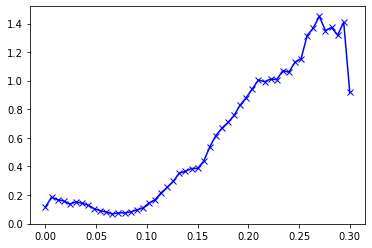

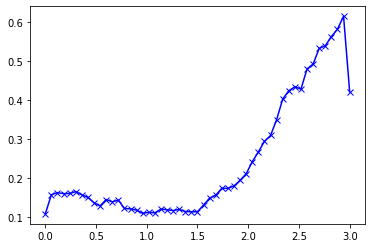

In [51]:
errors = np.convolve(np.array(g2_errors)[:, 1], np.ones(3)/3, mode='same')
plt.plot(np.array(g2_errors)[:, 0], errors, 'bx-')
plt.show()
errors = np.convolve(np.array(g1_errors)[:, 1], np.ones(3)/3, mode='same')
plt.plot(np.array(g1_errors)[:, 0], errors, 'bx-')
plt.show()
errors = np.convolve(np.array(g0_errors)[:, 1], np.ones(3)/3, mode='same')
plt.plot(np.array(g0_errors)[:, 0], errors, 'bx-')
plt.show()

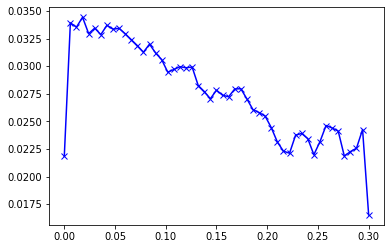

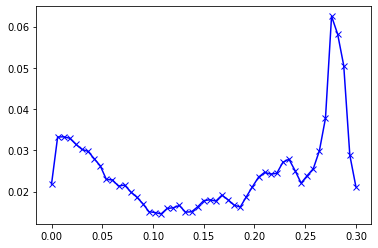

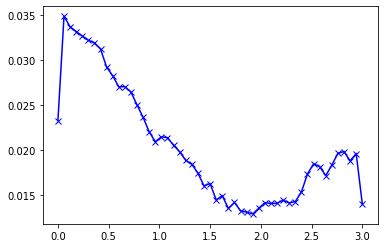

In [52]:
errors = np.convolve(np.array(g2_errors)[:, 2], np.ones(3)/3, mode='same')
plt.plot(np.array(g2_errors)[:, 0], errors, 'bx-')
plt.show()
errors = np.convolve(np.array(g1_errors)[:, 2], np.ones(3)/3, mode='same')
plt.plot(np.array(g1_errors)[:, 0], errors, 'bx-')
plt.show()
errors = np.convolve(np.array(g0_errors)[:, 2], np.ones(3)/3, mode='same')
plt.plot(np.array(g0_errors)[:, 0], errors, 'bx-')
plt.show()

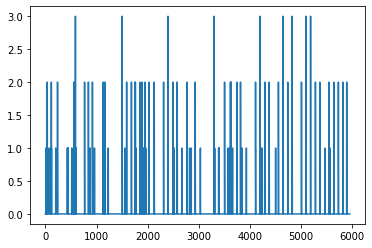

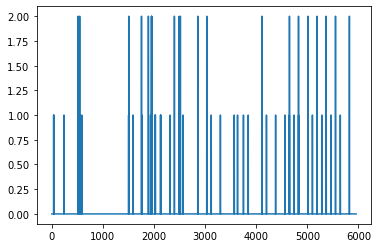

In [66]:
plt.plot(single_trial_bin[0,:,0])
plt.show()
plt.plot(pred_single_trial_try[0,:,0])
plt.show()

In [71]:
model.state_dict()

odict_keys(['bipolar.0.convs.0.weight', 'bipolar.0.convs.1.weight', 'bipolar.0.convs.2.weight', 'bipolar.0.convs.3.weight', 'bipolar.0.convs.4.weight', 'bipolar.0.convs.5.weight', 'bipolar.0.convs.6.weight', 'bipolar.0.convs.6.bias', 'bipolar.2.weight', 'bipolar.2.bias', 'bipolar.2.running_mean', 'bipolar.2.running_var', 'bipolar.2.num_batches_tracked', 'amacrine.1.convs.0.weight', 'amacrine.1.convs.1.weight', 'amacrine.1.convs.2.weight', 'amacrine.1.convs.3.weight', 'amacrine.1.convs.4.weight', 'amacrine.1.convs.4.bias', 'amacrine.3.weight', 'amacrine.3.bias', 'amacrine.3.running_mean', 'amacrine.3.running_var', 'amacrine.3.num_batches_tracked', 'ganglion.1.convs.0.weight', 'ganglion.1.convs.1.weight', 'ganglion.1.convs.2.weight', 'ganglion.1.convs.3.weight', 'ganglion.1.convs.3.bias', 'ganglion.3.weight', 'ganglion.3.bias', 'ganglion.3.running_mean', 'ganglion.3.running_var', 'ganglion.3.num_batches_tracked', 'ganglion.6.w'])

### New Polyfit

In [3]:
device = torch.device('cuda:6')
cfg = get_custom_cfg('fc_15-11-21b')
model_func = getattr(models, cfg.Model.name)
model_kwargs = dict(cfg.Model)
model = model_func(**model_kwargs).to(device)
checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack_FC_2/epoch_015_loss_-8.56_pearson_0.6841.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
test_data = DataLoader(TestDataset(cfg), batch_size=500)
test_pc, pred, targ = pearsonr_batch_eval(model, test_data, 11, device)

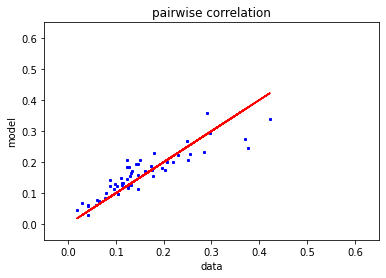

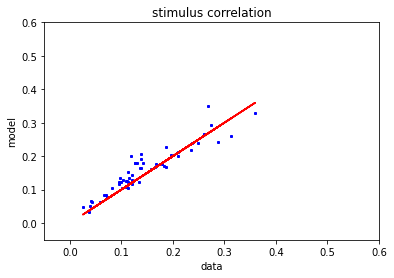

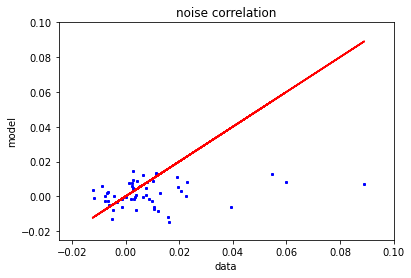

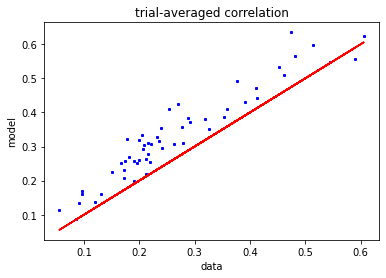

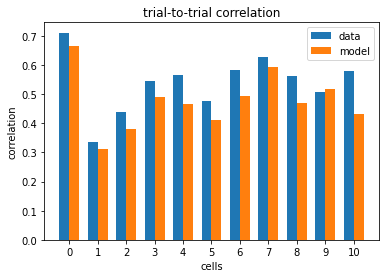

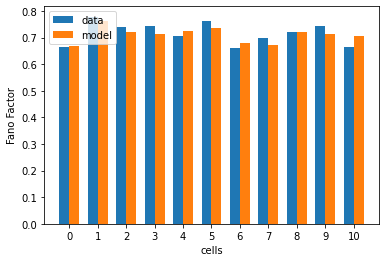

0.038594381988872245


In [84]:
binomial_para = [1.75, 1.62, 1.53, 1.48, 1.62, 1.41, 1.65, 1.23, 1.50, 1.38, 1.69]
t_list = [4, 3, 4, 4, 4, 4, 3, 3, 4, 4, 3]
poly_paras = poly_para_fit(recording, np.tile(pred, (6, 1, 1)), pred, thre=1, threshold=0.3, intv=0.5, sigma=True)
pred_single_trial_multi = model_single_trial_post_multi(np.tile(pred, (6, 1, 1)), binomial_para, t_list, poly_paras, pred, n_repeats=10, seed=None, thre=1)

min_error = 10
for i in range(10):
    pred_single_trial = pred_single_trial_multi[i]
    error = error_corr2(single_trial_bin, pred_single_trial)
    if error < min_error:
        min_error = error
        pred_single_trial_try = pred_single_trial
        
correlation_plot_2(single_trial_bin, pred_single_trial_try)
print(min_error)

0.5201559975363992 59.107407


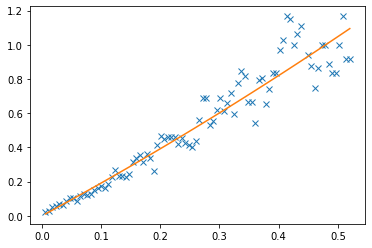

In [89]:
def poly(x,c,d):
        return c*x**2+d*x
    
cell = 2
means = []
rates = []
sigmas = []
for rate in np.linspace(0.6, pred[:, cell].max(), 100):
    mean, var, _, w = recording.stats_rate(pred, cell=cell, rate=rate, intv=0.5)
    if var > 0:
        sigmas.append(np.sqrt(var/(w-1)))
        means.append(mean)
        rates.append(rate/100)
sigmas = np.array(sigmas)[~np.isnan(means)]
rates = np.array(rates)[~np.isnan(means)]
means = np.array(means)[~np.isnan(means)]

max_idx = np.where(means >= 0.8 * means.max())[0][-1]
min_idx = np.where(rates == rates.min())[0][0]
slope = (means[max_idx] -  means[min_idx]) / (rates[max_idx] -  rates[min_idx])
means_res = means - (rates - rates[min_idx]) * slope - means[min_idx]
valid_idx = np.where(np.abs(means_res/means[max_idx]) < 0.3)

rates = rates[valid_idx]
means = means[valid_idx]
sigmas = sigmas[valid_idx]

para = curve_fit(poly, rates, means, sigma=sigmas)[0]

plt.plot(rates, means, 'x')
plt.plot(rates, [poly(rates[i], *para) for i in range(len(rates))])
print(rates.max(), pred[:, cell].max())

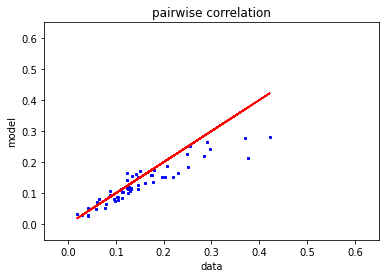

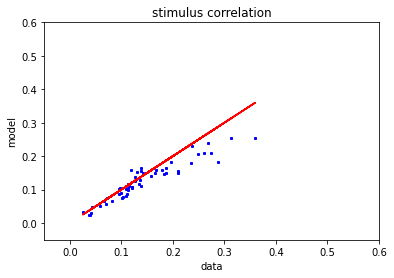

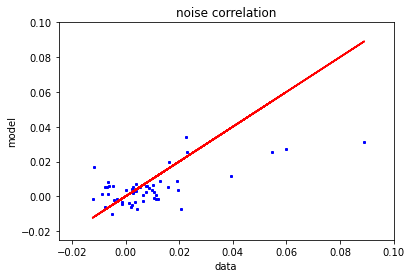

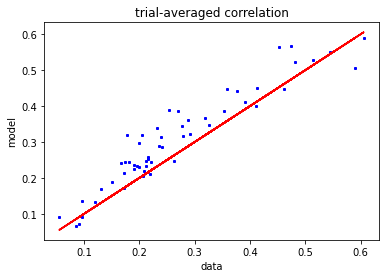

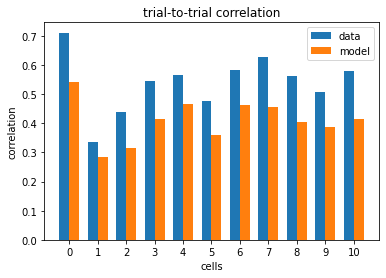

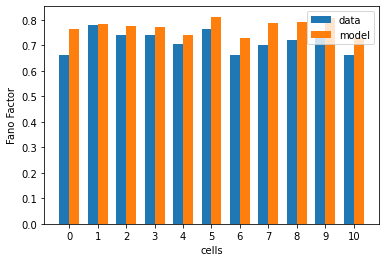

0.021340589705973044


In [97]:
binomial_para = [1.75, 1.62, 1.53, 1.48, 1.62, 1.41, 1.65, 1.23, 1.50, 1.38, 1.69]
t_list = [4, 3, 4, 4, 4, 4, 3, 3, 4, 4, 3]
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 6, [0., 0., 0.15, 0.], seed=None, noise_locs=[3,4,5])
poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=1, threshold=0.3, intv=0.5, sigma=True)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100, seed=None, thre=1)

min_error = 10
for i in range(100):
    pred_single_trial = pred_single_trial_multi[i]
    error = error_corr2(single_trial_bin, pred_single_trial)
    if error < min_error:
        min_error = error
        pred_single_trial_try = pred_single_trial
        
correlation_plot_2(single_trial_bin, pred_single_trial_try)
print(min_error)

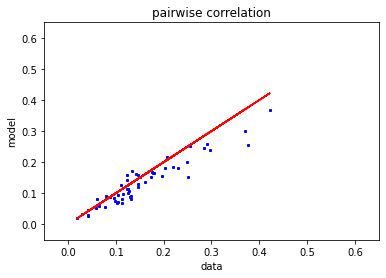

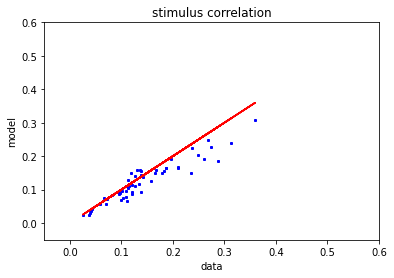

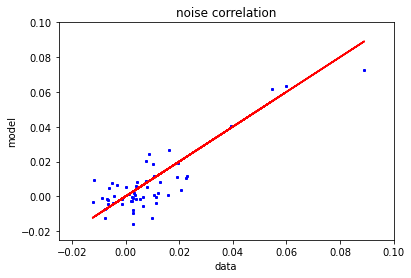

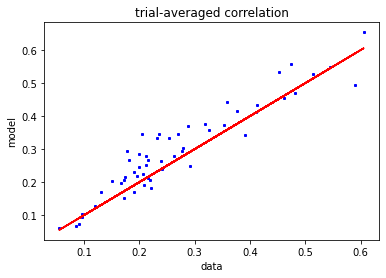

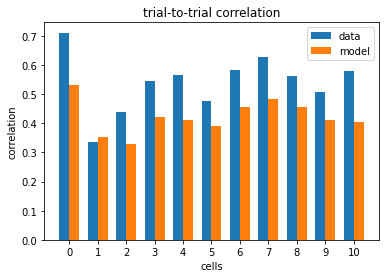

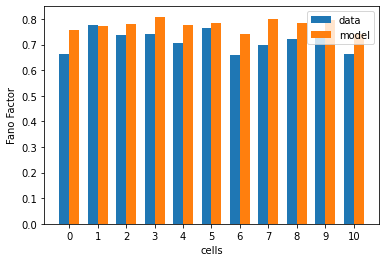

0.009874430370682167


In [93]:
binomial_para = [1.75, 1.62, 1.53, 1.48, 1.62, 1.41, 1.65, 1.23, 1.50, 1.38, 1.69]
t_list = [4, 3, 4, 4, 4, 4, 3, 3, 4, 4, 3]
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 6, [1.2, 0., 0., 0.], seed=None, noise_locs=[3,4,5])
poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=1, threshold=0.3, intv=0.5, sigma=True)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100, seed=None, thre=1)

min_error = 10
for i in range(100):
    pred_single_trial = pred_single_trial_multi[i]
    error = error_corr2(single_trial_bin, pred_single_trial)
    if error < min_error:
        min_error = error
        pred_single_trial_try = pred_single_trial
        
correlation_plot_2(single_trial_bin, pred_single_trial_try)
print(min_error)

In [111]:
g2_errors = []
g1_errors = []
g0_errors = []

t_list = [4, 3, 4, 4, 4, 4, 3, 3, 4, 4, 3]

for g2 in np.linspace(0., 0.3, 51):
    binomial_para = [1.75, 1.62, 1.53, 1.48, 1.62, 1.41, 1.65, 1.23, 1.50, 1.38, 1.69]
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 6, [0, 0, g2, 0], noise_locs=[3,4,5])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=6, threshold=0.3, intv=0.5, sigma=True)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, thre=6)
    
    min_error = 10
    
    for i in range(300):
        pred_single_trial = pred_single_trial_multi[i]
        _, stim_error, noise_error = error_corr3(single_trial_bin, pred_single_trial)
        if noise_error < min_error:
            min_error = noise_error
            min_error_stim = stim_error
         
    g2_errors.append((g2, min_error_stim, min_error))

for g1 in np.linspace(0., 0.3, 51):
    binomial_para = [1.75, 1.62, 1.53, 1.48, 1.62, 1.41, 1.65, 1.23, 1.50, 1.38, 1.69]
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 6, [0, g1, 0, 0],  noise_locs=[3,4,5])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=6, threshold=0.3, intv=0.5, sigma=True)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, thre=6)
    
    min_error = 10
    
    for i in range(300):
        pred_single_trial = pred_single_trial_multi[i]
        _, stim_error, noise_error = error_corr3(single_trial_bin, pred_single_trial)
        if noise_error < min_error:
            min_error = noise_error
            min_error_stim = stim_error
         
    g1_errors.append((g1, min_error_stim, min_error))

for g0 in np.linspace(0, 3, 51):
    binomial_para = [1.75, 1.62, 1.53, 1.48, 1.62, 1.41, 1.65, 1.23, 1.50, 1.38, 1.69]
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 6, [g0, 0, 0, 0],  noise_locs=[3,4,5])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=6, threshold=0.3, intv=0.5, sigma=True)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, thre=6)
    
    min_error = 10
    
    for i in range(300):
        pred_single_trial = pred_single_trial_multi[i]
        _, stim_error, noise_error = error_corr3(single_trial_bin, pred_single_trial)
        if noise_error < min_error:
            min_error = noise_error
            min_error_stim = stim_error
         
    g0_errors.append((g0, min_error_stim, min_error))

Stimulus correlation


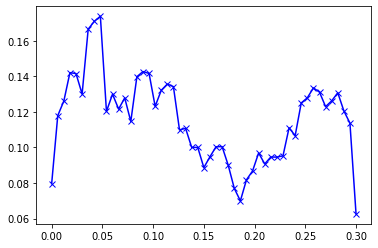

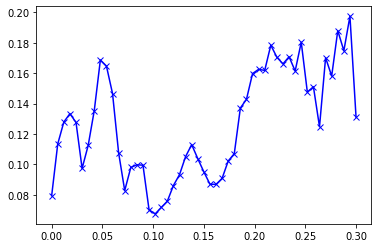

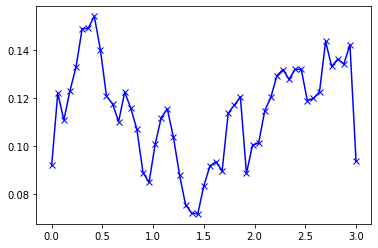

Noise correlation


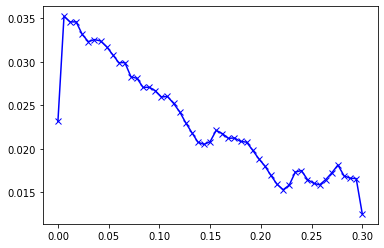

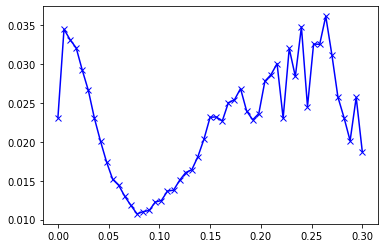

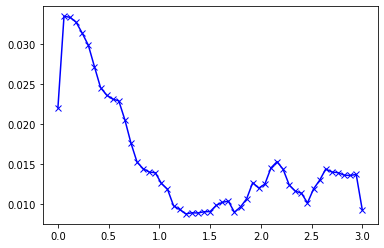

In [112]:
print("Stimulus correlation")
errors = np.convolve(np.array(g2_errors)[:, 1], np.ones(3)/3, mode='same')
plt.plot(np.array(g2_errors)[:, 0], errors, 'bx-')
plt.show()
errors = np.convolve(np.array(g1_errors)[:, 1], np.ones(3)/3, mode='same')
plt.plot(np.array(g1_errors)[:, 0], errors, 'bx-')
plt.show()
errors = np.convolve(np.array(g0_errors)[:, 1], np.ones(3)/3, mode='same')
plt.plot(np.array(g0_errors)[:, 0], errors, 'bx-')
plt.show()
print("Noise correlation")
errors = np.convolve(np.array(g2_errors)[:, 2], np.ones(3)/3, mode='same')
plt.plot(np.array(g2_errors)[:, 0], errors, 'bx-')
plt.show()
errors = np.convolve(np.array(g1_errors)[:, 2], np.ones(3)/3, mode='same')
plt.plot(np.array(g1_errors)[:, 0], errors, 'bx-')
plt.show()
errors = np.convolve(np.array(g0_errors)[:, 2], np.ones(3)/3, mode='same')
plt.plot(np.array(g0_errors)[:, 0], errors, 'bx-')
plt.show()

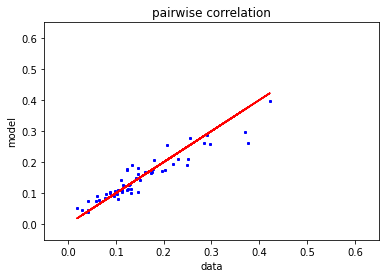

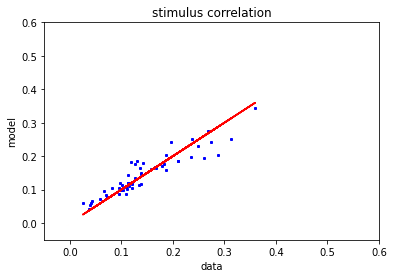

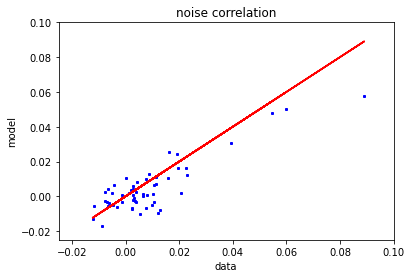

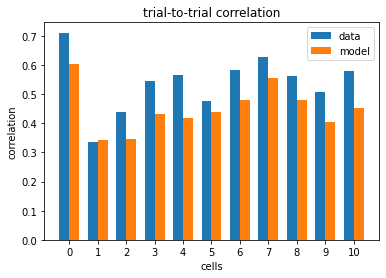

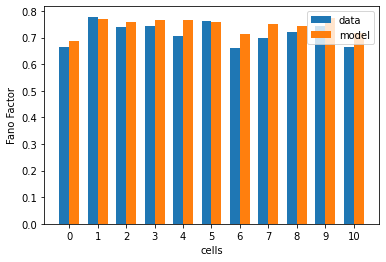

0.009867378845053322
20007.0 20106


In [102]:
binomial_para = [1.75, 1.62, 1.53, 1.48, 1.62, 1.41, 1.65, 1.23, 1.50, 1.38, 1.69]
t_list = [4, 3, 4, 4, 4, 4, 3, 3, 4, 4, 3]
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 6, [1., 0., 0., 0.], seed=None, noise_locs=[3,4,5])
poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=1.5, threshold=0.3, intv=0.5, sigma=True)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100, seed=None, thre=1.5)

min_error = 10
for i in range(100):
    pred_single_trial = pred_single_trial_multi[i]
    error = error_corr2(single_trial_bin, pred_single_trial)
    if error < min_error:
        min_error = error
        pred_single_trial_try = pred_single_trial
        
correlation_plot_2(single_trial_bin, pred_single_trial_try)
print(min_error)
print(single_trial_bin.sum(), pred_single_trial_try.sum())

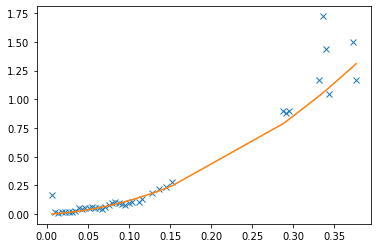

In [117]:
def poly(x,c,d):
        return c*x**2+d*x
    
cell = 5
means = []
rates = []
sigmas = []
thre = 1.5
pred_single_trial[:, pred<thre] = 0
for rate in np.linspace(0.6, pred_single_trial_pre.mean(0)[:, cell].max(), 100):
    mean, var, _, w = recording.stats_rate(pred_single_trial_pre.mean(0), cell=cell, rate=rate, intv=0.5)
    if var > 0:
        sigmas.append(np.sqrt(var/(w-1)))
        means.append(mean)
        rates.append(rate/100)
sigmas = np.array(sigmas)[~np.isnan(means)]
rates = np.array(rates)[~np.isnan(means)]
means = np.array(means)[~np.isnan(means)]

max_idx = np.where(means >= 0.8*means.max())[0][-1]
min_idx = np.where(rates == rates.min())[0][0]
slope = (means[max_idx] -  means[min_idx]) / (rates[max_idx] -  rates[min_idx])
means_res = means - (rates - rates[min_idx]) * slope - means[min_idx]
valid_idx = np.where(np.abs(means_res/means[max_idx]) < 0.3)

rates = rates[valid_idx]
means = means[valid_idx]
sigmas = sigmas[valid_idx]

para = curve_fit(poly, rates, means, sigma=sigmas)[0]

plt.plot(rates, means, 'x')
plt.plot(rates, [poly(rates[i], *para) for i in range(len(rates))])

In [7]:
for seed in range(100):
    binomial_para = [1.75, 1.62, 1.53, 1.48, 1.62, 1.41, 1.65, 1.23, 1.50, 1.38, 1.69]
    t_list = [4, 3, 4, 4, 4, 4, 3, 3, 4, 4, 3]
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 6, [1., 0., 0., 0.], seed=seed, noise_locs=[3,4,5])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=1.5, threshold=0.3, intv=0.5, sigma=True)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100, seed=seed, thre=1.5)

    min_error = 10
    for i in range(100):
        pred_single_trial = pred_single_trial_multi[i]
        error = error_corr2(single_trial_bin, pred_single_trial)
        if error < min_error:
            min_error = error
    print(seed, min_error)

0 0.011120437129814571
1 0.011097381955743068
2 0.0114882601668514
3 0.012780861924562863
4 0.012661205400489496
5 0.009163761170859618
6 0.01125656705679788
7 0.009378002208605313
8 0.012671112639239215
9 0.00997698521702188
10 0.011856853074029745
11 0.010516391266186574
12 0.012945876491639871
13 0.010856251117707431
14 0.009979541349659952
15 0.012144203243702287
16 0.01136378730658141
17 0.012655697194082108
18 0.010420470148528049
19 0.010587810898280293
20 0.009577242654843245
21 0.012464116593044408
22 0.012567154346269052
23 0.011717683201374082
24 0.011230237824373303
25 0.010261234032741118
26 0.010816549024549732
27 0.011818732628649119
28 0.012691341143765517
29 0.008472706198375084
30 0.010281713046115155
31 0.010608474012512324
32 0.01168466655859154
33 0.010581081548638708
34 0.009561112785999705
35 0.009740426565172886
36 0.011474297880947094
37 0.010707145028448333
38 0.008999060329801968
39 0.011029887310946973
40 0.01104151669485825
41 0.011566800916606338
42 0.0110

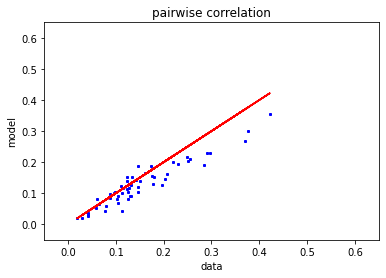

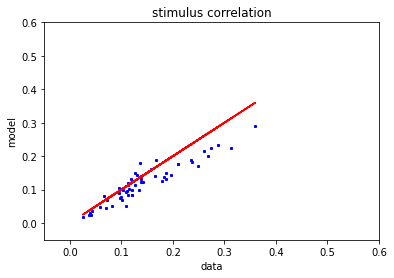

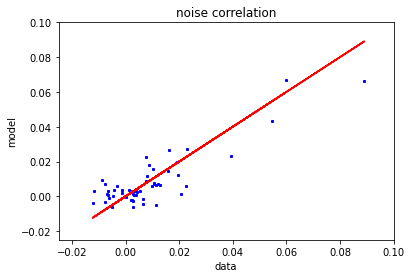

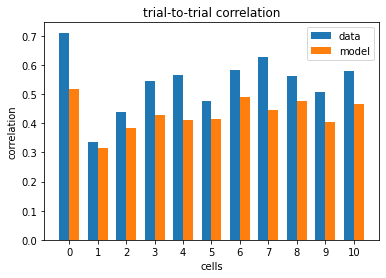

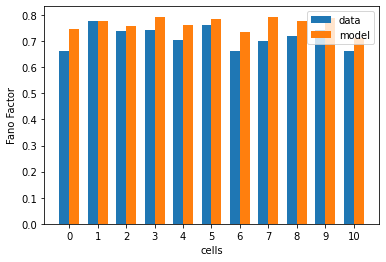

0.008472706198375084


In [11]:
binomial_para = [1.75, 1.62, 1.53, 1.48, 1.62, 1.41, 1.65, 1.23, 1.50, 1.38, 1.69]
t_list = [4, 3, 4, 4, 4, 4, 3, 3, 4, 4, 3]
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 6, [1., 0., 0., 0.], seed=29, noise_locs=[3,4,5])
poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=1.5, threshold=0.3, intv=0.5, sigma=True)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100, seed=29, thre=1.5)

min_error = 10
for i in range(100):
    pred_single_trial = pred_single_trial_multi[i]
    error = error_corr2(single_trial_bin, pred_single_trial)
    if error < min_error:
        min_error = error
        pred_single_trial_try = pred_single_trial
        
correlation_plot_2(single_trial_bin, pred_single_trial_try)
print(min_error)

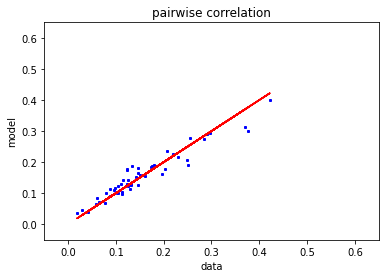

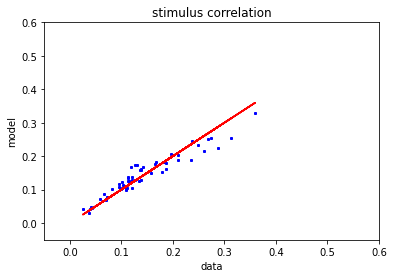

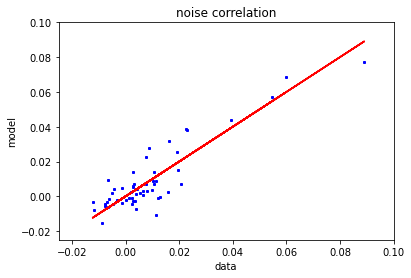

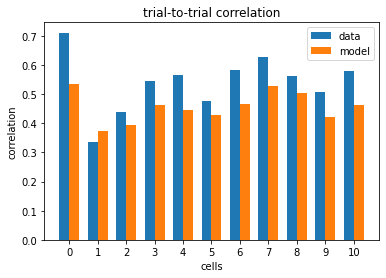

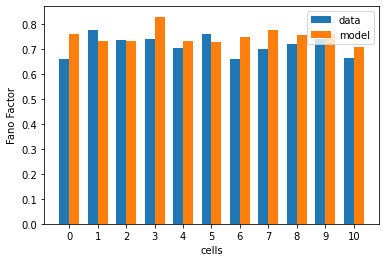

0.00800599904409154


In [88]:
binomial_para = [1.75, 1.62, 1.53, 1.48, 1.62, 1.41, 1.65, 1.23, 1.50, 1.38, 1.69]
t_list = [4, 3, 4, 4, 4, 4, 3, 3, 4, 4, 3]
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 6, [1.5, 0., 0., 0.], seed=None, noise_locs=[3,4,5])
poly_paras = poly_para_fit(recording, pred_single_trial_pre.copy(), pred, thre=5, threshold=0.3, intv=0.5, sigma=True)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100, seed=None, thre=5)

min_error = 10
for i in range(100):
    pred_single_trial = pred_single_trial_multi[i]
    error = error_corr2(single_trial_bin, pred_single_trial)
    if error < min_error:
        min_error = error
        pred_single_trial_try = pred_single_trial
        
correlation_plot_2(single_trial_bin, pred_single_trial_try)
print(min_error)

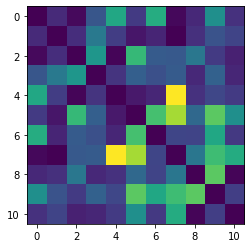

In [89]:
diff = np.abs(noise_corr2(single_trial_bin) - noise_corr2(pred_single_trial_try))
for i in range(11):
    diff[i, i] = 0
plt.imshow(diff)

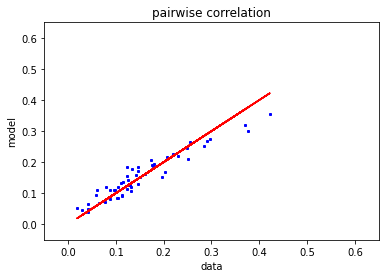

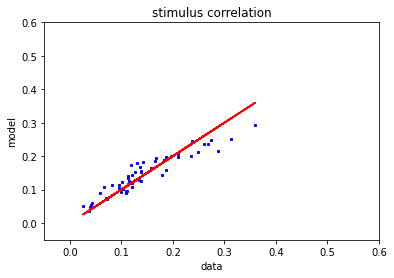

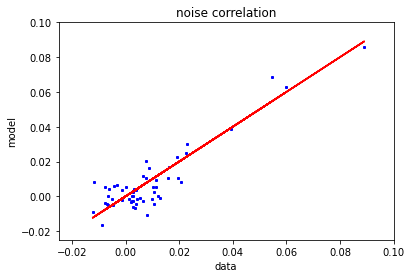

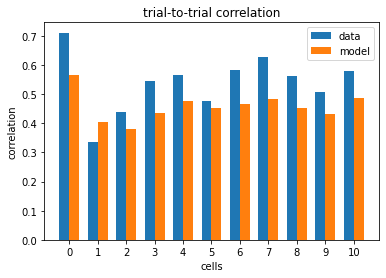

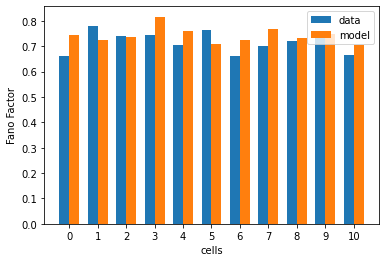

0.007102137460531457


In [96]:
binomial_para = [1.75, 1.62, 1.53, 1.48, 1.62, 1.41, 1.65, 1.23, 1.50, 1.38, 1.69]
t_list = [4, 3, 4, 4, 4, 4, 3, 3, 4, 4, 3]
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 6, [1.5, 0., 0., 0.], seed=33, noise_locs=[3,4,5])
poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=5, threshold=0.3, intv=0.5, sigma=True)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, seed=33, thre=5)

min_error = 10
for i in range(300):
    pred_single_trial = pred_single_trial_multi[i]
    error = error_corr2(single_trial_bin, pred_single_trial)
    if error < min_error:
        min_error = error
        pred_single_trial_try = pred_single_trial
        
correlation_plot_2(single_trial_bin, pred_single_trial_try)
print(min_error)

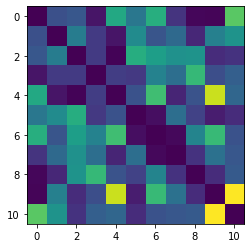

In [97]:
diff = np.abs(noise_corr2(single_trial_bin) - noise_corr2(pred_single_trial_try))
for i in range(11):
    diff[i, i] = 0
plt.imshow(diff)

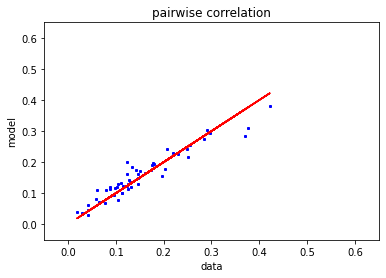

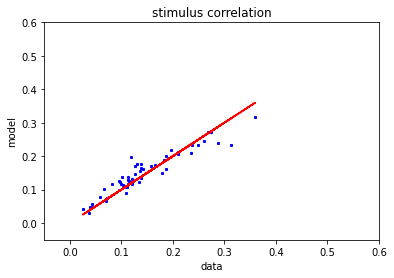

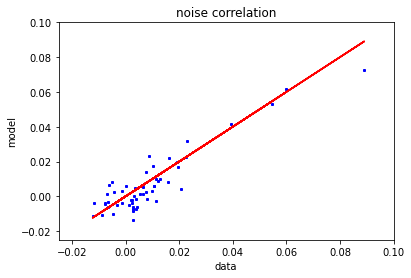

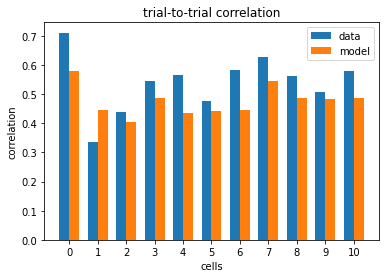

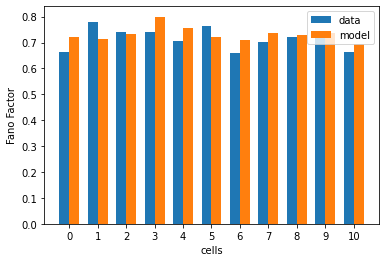

0.006200667800162775


In [5]:
binomial_para = [1.75, 1.62, 1.53, 1.48, 1.62, 1.41, 1.65, 1.23, 1.50, 1.38, 1.69]
t_list = [4, 3, 4, 4, 4, 4, 3, 3, 4, 4, 3]
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 6, [1.5, 0., 0., 0.], seed=58, noise_locs=[3,4,5])
poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=6, threshold=0.3, intv=0.5, sigma=True)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, seed=58, thre=6)

min_error = 10
for i in range(300):
    pred_single_trial = pred_single_trial_multi[i]
    error = error_corr2(single_trial_bin, pred_single_trial)
    if error < min_error:
        min_error = error
        pred_single_trial_try = pred_single_trial
        
correlation_plot_2(single_trial_bin, pred_single_trial_try)
print(min_error)

In [6]:
path = "./response_dict.npy"
date = "15-11-21b"
data = response_dict(path, date, single_trial_bin, pred_single_trial_try)

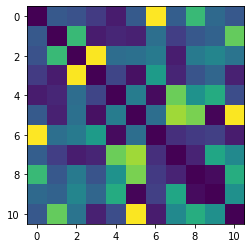

In [108]:
diff = np.abs(noise_corr2(single_trial_bin) - noise_corr2(pred_single_trial_try))
for i in range(11):
    diff[i, i] = 0
plt.imshow(diff)

In [95]:
for seed in range(100):
    binomial_para = [1.75, 1.62, 1.53, 1.48, 1.62, 1.41, 1.65, 1.23, 1.50, 1.38, 1.69]
    t_list = [4, 3, 4, 4, 4, 4, 3, 3, 4, 4, 3]
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 6, [1.5, 0., 0。, 0.], seed=seed, noise_locs=[3,4,5])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=5, threshold=0.3, intv=0.5, sigma=True)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, seed=seed, thre=5)

    min_error = 10
    for i in range(300):
        pred_single_trial = pred_single_trial_multi[i]
        error = error_corr2(single_trial_bin, pred_single_trial)
        if error < min_error:
            min_error = error
    print(seed, min_error)

0 0.008918969056115658
1 0.013859815083276071
2 0.010038145120025582
3 0.01050505617812786
4 0.009323065275153895
5 0.007568723466353366
6 0.009082783296541346
7 0.008409429046875812
8 0.009115751133010342
9 0.008682561507832644
10 0.008945262487697756
11 0.010582967663327976
12 0.009948253426808997
13 0.009315604333659137
14 0.011316915761851115
15 0.01400488146762895
16 0.008470377442428565
17 0.00945790764836859
18 0.009604984344550326
19 0.009750787419296608
20 0.01194152817323148
21 0.009929216444505187
22 0.012010792161222143
23 0.008488290510618127
24 0.009918541081451845
25 0.010597556850904449
26 0.008706445149492283
27 0.010908808644168854
28 0.00984682663971641
29 0.010472241530881523
30 0.009323655526667609
31 0.010618967162344874
32 0.009662533840625397
33 0.007102137460531457
34 0.009806946536729097
35 0.009926977727957365
36 0.00966496516841982
37 0.010000298515604885
38 0.009082353290533586
39 0.012164399867850324
40 0.009544274454303846
41 0.010606025731450553
42 0.009

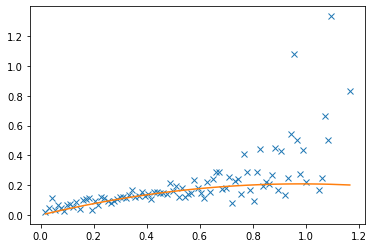

In [32]:
def poly(x,c,d):
        return c*x**2+d*x
    
cell = 2
means = []
rates = []
sigmas = []
thre = 1
pred_single_trial[:, pred<thre] = 0
for rate in np.linspace(0.6, pred_single_trial_pre.mean(0)[:, cell].max(), 100):
    mean, var, _, w = recording.stats_rate(pred_single_trial_pre.mean(0), cell=cell, rate=rate, intv=0.5)
    if var > 0:
        sigmas.append(np.sqrt(var/(w-1)))
        means.append(mean)
        rates.append(rate/100)
sigmas = np.array(sigmas)[~np.isnan(means)]
rates = np.array(rates)[~np.isnan(means)]
means = np.array(means)[~np.isnan(means)]

max_idx = np.where(means >= 0.8*means.max())[0][-1]
min_idx = np.where(rates == rates.min())[0][0]
slope = (means[max_idx] -  means[min_idx]) / (rates[max_idx] -  rates[min_idx])
means_res = means - (rates - rates[min_idx]) * slope - means[min_idx]
valid_idx = np.where(np.abs(means_res/means[max_idx]) < 1)

rates = rates[valid_idx]
means = means[valid_idx]
sigmas = sigmas[valid_idx]

para = curve_fit(poly, rates, means, sigma=sigmas)[0]

plt.plot(rates, means, 'x')
plt.plot(rates, [poly(rates[i], *para) for i in range(len(rates))])

In [6]:
testset = TestDataset(cfg)
X = torch.from_numpy((testset.X.astype('float32') - testset.stats['mean']) / testset.stats['std'])
output = inspect(model, X.to(device), ['bipolar.2', 'amacrine.3'])
s0 = np.abs(X).numpy().mean()
s1 = np.abs(output['bipolar.2']).mean()
s2 = np.abs(output['amacrine.3']).mean()
print((s0, s1, s2))

(0.72922426, 0.030213566, 0.022920867)


In [8]:
g0s, g1s, g2s, stim_errors, noise_errors, var_errors = read_search_result('./errors_15-11-21b.txt')

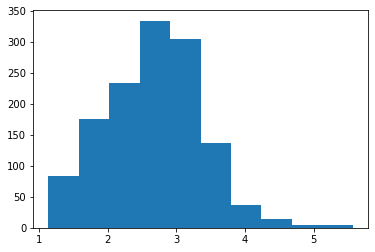

In [12]:
plt.hist(var_errors)
plt.show()

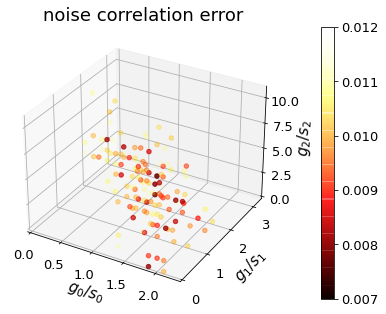

In [24]:
scatter_plot(g0s, g1s, g2s, stim_errors, noise_errors, var_errors, s0, s1, s2, noise_thre=0.012, stim_thre=0.1, var_thre=2.5, vmin=0.007)

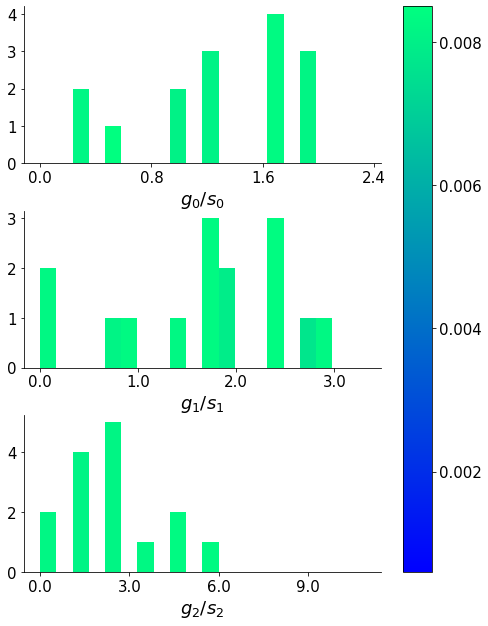

In [30]:
marginal_histogram(g0s, g1s, g2s, stim_errors, noise_errors, var_errors, s0, s1, s2, noise_thre=0.0085, stim_thre=0.1, var_thre=2.5, vmin=0.0006)

In [5]:
from torchdeepretina.utils import compute_sta
from pyret.filtertools import decompose

num_cells = 11

centers = []
for cell in range(num_cells):
    sta = compute_sta(model, 1, "ganglion", cell, verbose=False)
    s, _ = decompose(sta)
    center = np.where(np.abs(s) == np.abs(s).max())
    centers.append((center[0][0], center[1][0]))

def dist(a, b):
    return np.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

dists = []
for i in range(num_cells):
    for j in range(i+1, num_cells):
        dists.append(dist(centers[i], centers[j]))
dists = np.array(dists)

print(dists.max(), dists.mean())

12.041594578792296 6.026556700035535


### Test

In [31]:
device = torch.device('cuda:0')
cfg = get_custom_cfg('fc_phase2_15-11-21b')
model_func = getattr(models, cfg.Model.name)
model_kwargs = dict(cfg.Model)
model = model_func(**model_kwargs).to(device)
checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack_FC_2/epoch_095_loss_-121.43_pearson_0.9322.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
test_data = DataLoader(TestDataset(cfg), batch_size=500)
test_pc, pred, targ = pearsonr_batch_eval(model, test_data, 11, device)

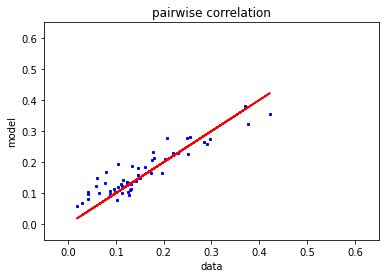

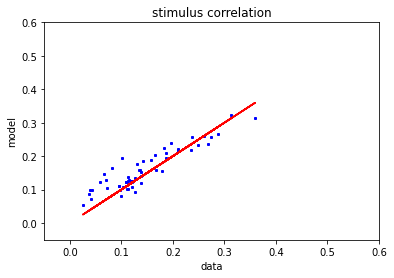

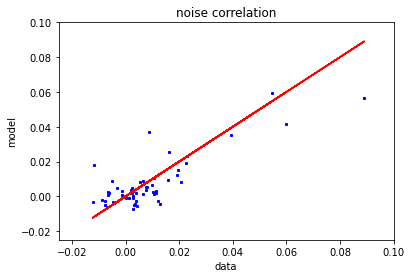

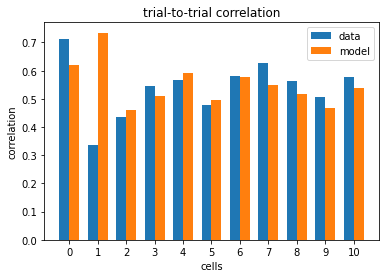

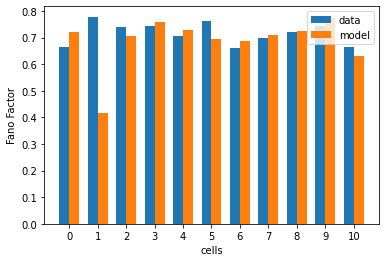

0.010808505407119222


In [50]:
binomial_para = [1.75, 1.62, 1.53, 1.48, 1.62, 1.41, 1.65, 1.23, 1.50, 1.38, 1.69]
t_list = [4, 3, 4, 4, 4, 4, 3, 3, 4, 4, 3]
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 6, [1.2, 0., 0., 0.], seed=58, noise_locs=[3,4,5])
poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=10, threshold=0.3, intv=0.5, sigma=True)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, seed=58, thre=10)

min_error = 10
for i in range(300):
    pred_single_trial = pred_single_trial_multi[i]
    error = error_corr2(single_trial_bin, pred_single_trial)
    if error < min_error:
        min_error = error
        pred_single_trial_try = pred_single_trial
        
correlation_plot_2(single_trial_bin, pred_single_trial_try)
print(min_error)